In [1]:
# Carregando dados
import scipy.io as sio
import numpy as np
cpString = 'CP3'

data_contents = sio.loadmat('../Data/dados' + cpString + '.mat')

inputMatrix = data_contents['inputMatrix'].T
fieldNames = data_contents['fieldNames']
freqPower = data_contents['power']
normalizedfreqPower = data_contents['normalizedPower']

feature_labels = [fieldNames[j][0][0] for j in range (fieldNames.size)]


target_file = sio.loadmat('../Data/target' + cpString + '.mat')
target = target_file['target']
target = np.argmax(target,axis=0)
outputs = target

cat_outputs = -np.ones([outputs.shape[0],len(np.unique(outputs))])
for i,j in enumerate(outputs):
    cat_outputs[i,j] = 1
    
    
comp_data = sio.loadmat('../Data/complementaryData' + cpString + '.mat')
channel = comp_data['channel']
triggerTime = comp_data['triggerTime'].T

class_labels = ['NP', 'SP', 'UP']

In [2]:
feature_labels

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16718855728674685753
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1475054796
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12301556470126735623
physical_device_desc: "device: 0, name: GeForce GTX 750 Ti, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [6]:
freq_data = sio.loadmat('../Data/frequencyDivisions.mat')
freqBins = freq_data['frequencyDivisions'].T

f = np.arange(0,1.25e6,1.25e6/freqPower.shape[1])

freqData = np.zeros((int(freqBins.shape[0]/2), freqPower.shape[1]))
i=0;
for i, k in enumerate(range(0,freqBins.shape[0],2)):
    auxIndexes = np.where((f>=freqBins[k]) & (f<freqBins[k+1]))
    freqData[i,:] = np.mean(normalizedfreqPower[auxIndexes[0],:])
    
inputMatrix = np.concatenate((inputMatrix, freqData.T), axis = 1)


In [19]:
from sklearn.utils import class_weight
cw = class_weight.compute_class_weight('balanced',np.unique(target),target )
print(cw)
print(target)
print(len(range(0, 5+1, 5)))

aaa = np.ones((5,3,3))
print(np.sum(np.sum(np.mean(aaa,axis=0))))

print(np.mean(aaa,axis=0))
(3./3)

[1.48596851 0.91256831 0.81219603]
[0 0 0 ... 2 2 2]
2
9.0
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


1.0

In [44]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn import preprocessing
from sklearn.externals import joblib
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

import os
from Functions import models
from Functions.aux_func import *

#Time sequentializing data
sortIndexes = np.argsort(triggerTime,axis=0)[:,0]
outputs = outputs[sortIndexes].reshape((outputs.shape[0],1))
inputMatrix = inputMatrix[sortIndexes]
trainPercentage = 0.7
testPercentage = 0.3

nn_models = {}
n_neurons = 16
nn_params = models.NeuralNetworkParams(learning_rate=0.005,
                                       n_epochs=500,
                                       batch_size=3,
                                       verbose=True, 
                                       n_inits=1)
MAX_RUNS = 1

MAX_SAMPLE_SIZE = 5


confusionMatrixRecord = np.zeros( (len(range(5,MAX_SAMPLE_SIZE+1,5)), len(range(0,MAX_SAMPLE_SIZE+1,5)), 2, 3, 3) )
accRecord = -1*np.ones((len(range(5,35,5)), len(range(0,35+1,5)), 3))

for i, sampleSize in enumerate(range(5, MAX_SAMPLE_SIZE+1, 5)):
    for j, delta in enumerate(range(0, sampleSize+1, 5)):

        dummy, targetLSTM = createLSTMInput(inputMatrix, outputs, sampleSize, delta+1)

        spIndexes = np.where(targetLSTM == 0)[0]
        peIndexes = np.where(targetLSTM == 1)[0]
        piIndexes = np.where(targetLSTM == 2)[0]


        trainIndexes = np.concatenate((spIndexes[0:int(spIndexes.size*trainPercentage)], peIndexes[0:int(peIndexes.size*trainPercentage)], piIndexes[0:int(piIndexes.size*trainPercentage)]))
        testIndexes = np.concatenate((spIndexes[-int(spIndexes.size*testPercentage):], peIndexes[-int(peIndexes.size*testPercentage):], piIndexes[-int(piIndexes.size*testPercentage):]))

        scaler = preprocessing.StandardScaler().fit(inputMatrix[trainIndexes])
        normalized_inputs = scaler.transform(inputMatrix)

        inputLSTM, dummy = createLSTMInput(normalized_inputs,outputs, sampleSize, delta+1)
        T = len(testIndexes)

        cw = class_weight.compute_class_weight('balanced',np.unique(targetLSTM[trainIndexes]).flatten(),targetLSTM[trainIndexes].flatten())
        cw = dict(enumerate(cw))

        cm = np.zeros((MAX_RUNS,3,3))
        print("{}%  overlap".format(100-100.0*(delta+1.0)/sampleSize))
        print("{} total samples".format(T))

        for runs in range(0,MAX_RUNS):
            nn_models[runs] = models.LSTMModel()

            nn_models[runs].loss = 'categorical_crossentropy'
            nn_models[runs].optimizer = 'rmsprop'

            print('starting fit')
            nn_models[runs].fit(inputs=inputLSTM,
                                 outputs = catToSparse(targetLSTM),
                                 train_indexes=[trainIndexes, testIndexes],
                                 n_neurons=n_neurons, trn_params=nn_params, 
                                 activation_functions=['tanh', 'softmax'],
                                 class_weight = cw)
            
            nnOutputTest = np.argmax(nn_models[0].predict(inputLSTM[testIndexes]),axis=1)
            classTestOutput = np.argmax(catToSparse(targetLSTM[testIndexes]),axis=1)
            cm[runs] = confusion_matrix(classTestOutput, nnOutputTest)

        std_cm = np.std(cm/T,axis=0)
        cm = np.mean(cm,axis=0)
        accRecord[i,j,0] = cm[0,0].astype('float')/T
        accRecord[i,j,1] = cm[1,1].astype('float')/T
        accRecord[i,j,2] = cm[2,2].astype('float')/T
        confusionMatrixRecord[i,j,0] = cm
        confusionMatrixRecord[i,j,1] = std_cm
        print(cm)


np.save('cmRecord', confusionMatrixRecord)
np.save('accRecord', accRecord)
    #nn_models.save('%s_%i_neurons_%i_fold'%(nn_models[ifold].get_str(), 
     #                                            n_neurons,ifold),
      #                    '../Results/NeuralNetwork')

80.0%  overlap
648 total samples
starting fit
Neural Network Model - train 1 initialization


KeyboardInterrupt: 

576

In [3]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn import preprocessing
from sklearn.externals import joblib
from sklearn.utils import class_weight

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

import os
from Functions import models
from Functions.aux_func import *

#Creates the train/test indexes
sortIndexes = np.argsort(triggerTime,axis=0)[:,0]
outputs = outputs[sortIndexes].reshape((outputs.shape[0],1))
inputMatrix = inputMatrix[sortIndexes]


nn_models = {}
n_neurons = 16
nn_params = models.NeuralNetworkParams(learning_rate=0.005,
                                       n_epochs=500,
                                       batch_size=1,
                                       verbose=True, 
                                       n_inits=2)


sampleSize = 20
delta = 18

dummy, targetLSTM = createLSTMInput(inputMatrix, outputs, sampleSize, delta)

spIndexes = np.where(targetLSTM == 0)[0]
piIndexes = np.where(targetLSTM == 2)[0]
peIndexes = np.where(targetLSTM == 1)[0]

trainPercentage = 0.7
testPercentage = 0.3

trainIndexes = np.concatenate((spIndexes[0:int(spIndexes.size*trainPercentage)], peIndexes[0:int(peIndexes.size*trainPercentage)], piIndexes[0:int(piIndexes.size*trainPercentage)]))
testIndexes = np.concatenate((spIndexes[-int(spIndexes.size*testPercentage):], peIndexes[-int(peIndexes.size*testPercentage):], piIndexes[-int(piIndexes.size*testPercentage):]))

scaler = preprocessing.StandardScaler().fit(inputMatrix[trainIndexes])
normalized_inputs = scaler.transform(inputMatrix)

inputLSTM, dummy = createLSTMInput(normalized_inputs,outputs, sampleSize, delta)

cw = class_weight.compute_class_weight('balanced',np.unique(targetLSTM[trainIndexes]).flatten(),targetLSTM[trainIndexes].flatten())
cw = dict(enumerate(cw))

for runs in range(0,2):
    nn_models[runs] = models.LSTMModel()

    nn_models[runs].loss = 'categorical_crossentropy'
    nn_models[runs].optimizer = 'rmsprop'

    nn_models[runs].fit(inputs=inputLSTM,
                         outputs = catToSparse(targetLSTM),
                         train_indexes=[trainIndexes, testIndexes],
                         n_neurons=n_neurons, trn_params=nn_params, 
                         activation_functions=['tanh', 'softmax'],
                         class_weight = cw)
    print(runs)
    #nn_models.save('%s_%i_neurons_%i_fold'%(nn_models[ifold].get_str(), 
     #                                            n_neurons,ifold),
      #                    '../Results/NeuralNetwork')

Neural Network Model - train 1 initialization


KeyboardInterrupt: 

In [31]:
#targetLSTM[trainIndexes].shape

cw = class_weight.compute_class_weight('balanced',np.unique(targetLSTM[trainIndexes]).flatten(),targetLSTM[trainIndexes].flatten())
cw = dict(enumerate(cw))



In [32]:
cw

{0: 1.5009980039920159, 1: 0.9049338146811071, 2: 0.8138528138528138}

In [91]:
sortIndexes = np.argsort(triggerTime,axis=0)[:,0]
outputs = outputs[sortIndexes].reshape((outputs.shape[0],1))
inputMatrix = inputMatrix[sortIndexes]
triggerTime = triggerTime[sortIndexes]

spIndexes = np.where(triggerTime <= 3000)[0]
piIndexes = np.where(triggerTime >= 9000)[0]
peIndexes = np.where( (triggerTime > 3000) & (triggerTime < 9000) )[0]

trainPercentage = 0.7
testPercentage = 0.3

trainIndexes = np.concatenate((spIndexes[0:int(spIndexes.size*trainPercentage)], peIndexes[0:int(peIndexes.size*trainPercentage)], piIndexes[0:int(piIndexes.size*trainPercentage)]))
testIndexes = np.concatenate((spIndexes[-int(spIndexes.size*testPercentage):], peIndexes[-int(peIndexes.size*testPercentage):], piIndexes[-int(piIndexes.size*testPercentage):]))



In [88]:
triggerTime

array([[1040.2113568],
       [1040.2114108],
       [1040.2131584],
       ...,
       [9540.7856592],
       [9540.7912052],
       [9540.7913932]])

In [19]:
targetLSTM.shape
spIndexes = np.where(targetLSTM == 0)[0]
piIndexes = np.where(targetLSTM == 2)[0]
peIndexes = np.where(targetLSTM == 1)[0]

trainPercentage = 0.7
testPercentage = 0.3

trainIndexes = np.concatenate((spIndexes[0:int(spIndexes.size*trainPercentage)], peIndexes[0:int(peIndexes.size*trainPercentage)], piIndexes[0:int(piIndexes.size*trainPercentage)]))
testIndexes = np.concatenate((spIndexes[-int(spIndexes.size*testPercentage):], peIndexes[-int(peIndexes.size*testPercentage):], piIndexes[-int(piIndexes.size*testPercentage):]))



In [65]:
N = 50; P = 1;
data = np.zeros((N,P))
data[0:int(N/2),:] = 1*np.random.randn(int(N/2),P)+0
data[int(N/2):,:] = 1*np.random.randn(int(N/2),P)+2

target = np.zeros((N,1))
target[int(N/2):,0] = 1;

dataLSTM, targetLSTM = createLSTMInput(target,target, 7, 4)


In [58]:
import numpy as np
def createLSTMInput(data,target, sampleSize, step):
    if step > sampleSize: 
        step = sampleSize
    indexRange = range(0,data.shape[0]-sampleSize+1,step)
    outputData = np.zeros((len(indexRange), sampleSize, data.shape[1]))
    targetTensor = np.zeros((len(indexRange), sampleSize, target.shape[1]))
    outputTarget = np.zeros((len(indexRange), 1))
    for index, k in enumerate(indexRange):
        outputData[index,:,:] = data[k:(k+sampleSize),:]
        targetTensor[index,:,:] = target[k:(k+sampleSize),:]
        classes, count = np.unique(targetTensor[index,:,:],return_counts=True)
        outputTarget[index,0] = classes[np.argmax(count)]
    return outputData, outputTarget

(15, 2171)

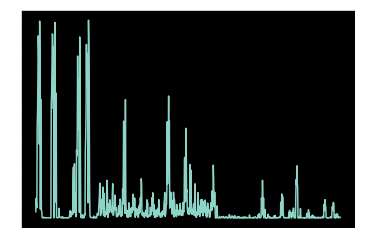

In [50]:
plt.figure()
plt.plot(normalized_inputs[testIndexes,1])


inputMatrix.shape

In [40]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.externals import joblib

import os

from Functions import models

iris = datasets.load_iris()

inputs = iris.data  
outputs = iris.target

#print inputs.shape
#print outputs.shape


n_folds = 2

folds_filename =  '../Results/StratifiedKFolds_%i_folds.jbl'%(n_folds)

if not os.path.isfile(folds_filename):
    skf = StratifiedKFold(n_splits=n_folds)
    skf.get_n_splits(inputs, outputs)
    joblib.dump(skf, folds_filename)
else:
    skf = joblib.load(folds_filename)

cat_outputs = -np.ones([outputs.shape[0],len(np.unique(outputs))])
for i,j in enumerate(outputs):
    cat_outputs[i,j] = 1

nn_models = {}

nn_params = models.NeuralNetworkParams(learning_rate=0.1,n_epochs=200,batch_size=16,verbose=True, n_inits=4)

n_neurons = 9

for ifold, [train_index, test_index] in enumerate(skf.split(inputs, outputs)):
    #if ifold > 0:        
    #    continue
    #normalize data
    scaler = preprocessing.StandardScaler().fit(inputs[train_index,:])
    normalized_inputs = scaler.transform(inputs)
    
    nn_models[ifold] = models.NeuralNetworkModel()
    nn_models[ifold].loss = 'categorical_crossentropy'
    nn_models[ifold].optimizer = 'sgd'
    
    nn_models[ifold].fit(inputs=normalized_inputs, 
                         outputs=cat_outputs,
                         train_indexes=[train_index, test_index],
                         n_neurons=n_neurons, trn_params=nn_params, 
                         activation_functions=['relu', 'softmax'])
    nn_models[ifold].save('%s_%i_neurons_%i_fold'%(nn_models[ifold].get_str(), 
                                                   n_neurons,ifold),
                          '../Results/NeuralNetwork')

Neural Network Model - train 1 initialization
min loss: 9999.00000, model loss: 0.69649
Neural Network Model - train 2 initialization
min loss: 0.69649, model loss: 0.69403
Neural Network Model - train 3 initialization
Neural Network Model - train 4 initialization
Neural Network Model - train 1 initialization
min loss: 9999.00000, model loss: 0.72528
Neural Network Model - train 2 initialization
min loss: 0.72528, model loss: 0.72407
Neural Network Model - train 3 initialization
min loss: 0.72407, model loss: 0.72012
Neural Network Model - train 4 initialization


In [41]:
import os
import numpy as np
from Functions import models

from sklearn import datasets
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.externals import joblib

iris = datasets.load_iris()

inputs = iris.data  
outputs = iris.target
cat_outputs = -np.ones([outputs.shape[0],len(np.unique(outputs))])

nn_params = models.NeuralNetworkParams(learning_rate=0.01,n_epochs=200,batch_size=16,verbose=True, n_inits=4)
n_neurons = 9

n_folds = 2
folds_filename =  '../Results/StratifiedKFolds_%i_folds.jbl'%(n_folds)

if os.path.isfile(folds_filename):
    skf = joblib.load(folds_filename)
    for i,j in enumerate(outputs):
        cat_outputs[i,j] = 1
    cat_outputs = -np.ones([outputs.shape[0],len(np.unique(outputs))])

    nn_test_models = {}
    for ifold, [train_index, test_index] in enumerate(skf.split(inputs, outputs)):
        scaler = preprocessing.StandardScaler().fit(inputs[train_index,:])
        normalized_inputs = scaler.transform(inputs)
        
        nn_test_models[ifold] = models.NeuralNetworkModel()
        nn_test_models[ifold].loss = 'categorical_crossentropy'
        nn_test_models[ifold].optimizer = 'sgd'
    
        nn_test_models[ifold].load('%s_%i_neurons_%i_fold'%(nn_models[ifold].get_str(),n_neurons,ifold),'../Results/NeuralNetwork')
else:
    print "No trained model"

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')
n_folds = len(nn_models)-1
nn_test_models = nn_models
fig = plt.figure(figsize=(10,5))
nrows = 2
ncols = 2
for ifold in range(n_folds):
    ax = plt.subplot(nrows,ncols,ifold+1)
    epochs = range(len(nn_models[ifold].trn_desc['acc']))
    ax.plot(epochs,nn_models[ifold].trn_desc['loss'],'b')
    ax.plot(epochs,nn_models[ifold].trn_desc['val_loss'],'g')

<Figure size 720x360 with 0 Axes>

In [40]:
nnOutputTest = np.argmax(nn_models[0].predict(inputLSTM[testIndexes]),axis=1)
nnOutputTest
nn_models[0].trn_desc['acc']

TypeError: 'NoneType' object is not subscriptable

In [4]:
nnOutputTest = np.argmax(nn_models[0].predict(inputLSTM[testIndexes]),axis=1)

classTestOutput = np.argmax(auxFunc.catToSparse(targetLSTM[testIndexes]),axis=1)
classTestOutput

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

In [5]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(classTestOutput, nnOutputTest)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm)

[[0.875      0.125      0.        ]
 [0.07692308 0.92307692 0.        ]
 [0.         0.         1.        ]]


In [2]:
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import numpy as np
from Functions import models

def catToSparse(target):
    cat_outputs = -np.ones([target.shape[0],len(np.unique(target))])
    for i,j in enumerate(target):
        cat_outputs[i,int(j)] = 1
    return cat_outputs

class tteOutput:
    def __init__(self):
        self.cost =[]
        self.cm = np.zeros((1000,2,2))
        self.minCost = 99999;
        self.time = []


def TTE(data, timestep, typeStr, modelConstructor):
    target = np.ones((data.shape[0] if data.shape[0]>data.shape[1] else data.shape[1],1))
    trPerc = 0.6
    testPerc = 0.4
    output = tteOutput();
    output.minCost = 999999;
    index = 0;
    
    if typeStr == 'moving':
        windowLength = 100
        leftLength = int(windowLength/2)
        rightLength = leftLength
        minTime = int(windowLength/2)
        maxTime = data.shape[0] - minTime
        tList = list(range(minTime, maxTime, timestep))
        leftLength = np.array([leftLength]*len(tList))
        rightLength = np.array([rightLength]*len(tList))

    if typeStr == 'fixed':
        windowLength = data.shape[0]
        minTime = 20
        maxTime = data.shape[0] - minTime
        tList = list(range(minTime, maxTime, timestep))
        leftLength = np.array(tList)
        rightLength = data.shape[0] - leftLength
        
    if typeStr == 'other':
        minTime = 20
        maxTime = data.shape[0] - minTime
        leftLength = []
        rightLength = []
        tList = list(range(minTime, maxTime, timestep))
        
        for t in tList:
            if t <= data.shape[0]/2:
                leftLength.append(t)
                rightLength.append(t)
            else:
                rightLength.append(data.shape[0]-t)
                leftLength.append(data.shape[0]-t)
            
    for t in tList:
        
        inputs = data[int(t-leftLength[index]):int(rightLength[index]+t),:]
        target[0:t] = 0;
        sparseTargets = catToSparse(target[int(t-leftLength[index]):int(rightLength[index]+t),:])
        
        inputTrain, inputTest, targetTrain, targetTest = \
        tts(inputs,sparseTargets,test_size=testPerc)

        scaler = preprocessing.StandardScaler().fit(inputTrain)
        inputTrain = scaler.transform(inputTrain)
        nn_params = models.NeuralNetworkParams(learning_rate=0.1,n_epochs=200,batch_size=16,verbose=True, n_inits=4)

        model = modelConstructor()
        model.params=nn_params;
        model.loss = 'categorical_crossentropy'
        model.optimizer = 'sgd'
        model.fit(inputTrain,targetTrain,[inputTest,targetTest])
        output.cost.append(np.min(model.trn_desc['val_loss']))
        outTarget = np.argmax(model.predict(inputTest),axis=1)
        output.cm[index, :,:] = confusion_matrix(np.argmax(targetTest,axis=1), outTarget)
        output.time.append(t);

        if output.cost[index] < output.minCost:
            output.minCost = output.cost[index]
        print(index)
        index = index+1;
        
    return output



In [ ]:
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import numpy as np
from Functions import models

class tteOutput:
    def __init__(self):
        self.cost =[]
        self.cm = np.zeros((1000,2,2))
        self.minCost = 99999;


def TTE(data, timestep, typeStr, modelConstructor):
    target = np.ones((data.shape[0] if data.shape[0]>data.shape[1] else data.shape[1],1))
    trPerc = 0.6
    testPerc = 0.4
    output = tteOutput();
    output.minCost = 999999;
    
    if typeStr=='hard':
        S = 100
        target = target[0:S]
        target[0:(int(target.shape[0]/2))] = 0;

        cat_outputs = -np.ones([target.shape[0],len(np.unique(target))])
        for i,j in enumerate(target):
            cat_outputs[i,int(j)] = 1
        target = cat_outputs;
        output.cost = []
        output.cm = np.zeros((1000,2,2))
        index = 0;
        for t in range(int(S/2),data.shape[0]-int(S/2)+1,timestep):
            inputs = data[int(t-S/2):int(S/2+t),:]
            inputTrain, inputTest, targetTrain, targetTest = \
            tts(inputs,target,test_size=testPerc)

            scaler = preprocessing.StandardScaler().fit(inputTrain)
            inputTrain = scaler.transform(inputTrain)

            nn_params = models.NeuralNetworkParams(learning_rate=0.1,n_epochs=200,batch_size=16,verbose=True, n_inits=4)

            model = modelConstructor()
            model.params=nn_params;
            model.loss = 'categorical_crossentropy'
            model.optimizer = 'sgd'
            model.fit(inputTrain,targetTrain,[inputTest,targetTest])
            output.cost.append(np.min(model.trn_desc['val_loss']))
            outTarget = np.argmax(model.predict(inputTest),axis=1)
            output.cm[int(t-S/2), :,:] = confusion_matrix(np.argmax(targetTest,axis=1), outTarget)

            if output.cost[index] < output.minCost:
                output.minCost = output.cost[index]
            index = index+1;
            print(index)
    #elif typeStr =='soft':
    elif typeStr =='moving':
        MIN = 20
        inputs = data
        index = 0
        for t in range(MIN, data.shape[0]-MIN,timestep):
            target = np.ones((data.shape[0] if data.shape[0]>data.shape[1] else data.shape[1],1))
            target[0:t,:] = 0;
            cat_outputs = -np.ones([target.shape[0],len(np.unique(target))])
            for i,j in enumerate(target):
                cat_outputs[i,int(j)] = 1
            target = cat_outputs;
            inputTrain, inputTest, targetTrain, targetTest = \
            tts(inputs,target,test_size=testPerc)

            scaler = preprocessing.StandardScaler().fit(inputTrain)
            inputTrain = scaler.transform(inputTrain)

            nn_params = models.NeuralNetworkParams(learning_rate=0.1,n_epochs=200,batch_size=16,verbose=True, n_inits=2)

            model = modelConstructor()
            model.params=nn_params;
            model.loss = 'categorical_crossentropy'
            model.optimizer = 'sgd'
            model.fit(inputTrain,targetTrain,[inputTest,targetTest])
            output.cost.append(np.min(model.trn_desc['val_loss']))
            outTarget = np.argmax(model.predict(inputTest),axis=1)
            output.cm[t, :,:] = confusion_matrix(np.argmax(targetTest,axis=1), outTarget)

            if output.cost[index] < output.minCost:
                output.minCost = output.cost[index]
            index = index+1;
            print(index)
    return output



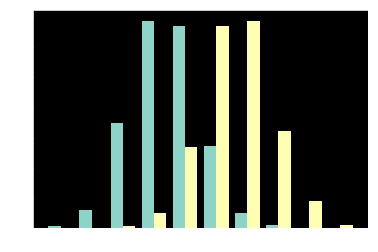

InternalError: GPU sync failed

In [2]:
import numpy as np
from Functions import models
from Functions.aux_func import *
import matplotlib.pyplot as plt
plt.style.use('dark_background')
%matplotlib inline


N = 2100; P = 2;
data = np.zeros((N,P))

MU_0 = 0
MU_1 = 2

STD_0 = 1
STD_1 = 1

data[0:int(N/2),:] = STD_0*np.random.randn(int(N/2),P)+MU_0
data[int(N/2):,:] = STD_1*np.random.randn(int(N/2),P)+MU_1

plt.hist([data[0:int(N/2),0], data[int(N/2):,0]])
plt.show()



nn_params = models.NeuralNetworkParams(learning_rate=0.05,n_epochs=400,batch_size=8,verbose=True, n_inits=2)

n_neurons = 5


nnmodel = models.NeuralNetworkModel()
nnmodel.loss = 'categorical_crossentropy'
nnmodel.optimizer = 'sgd'

output = TTE(data, 105, 'moving', models.NeuralNetworkModel)

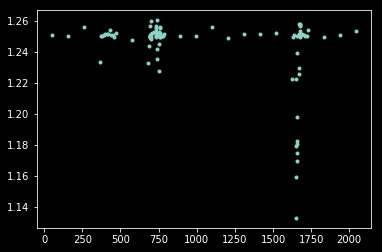

1652


In [8]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

plt.figure()
plt.plot(output.time, output.cost,'.')
plt.show()


print(output.time[np.argmin(output.cost)])

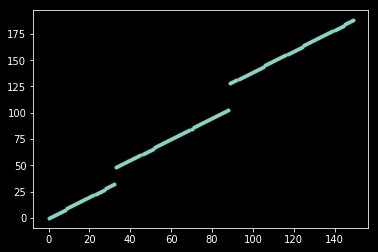

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,
       182, 183, 184, 185, 186, 187, 188], dtype=int64)

In [34]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

plt.figure()
plt.plot(trainIndexes,'.')
plt.show()
trainIndexes

In [ ]:
correlation_sort_indexes = np.array([0,6,7,1,2,3,5,4,8,9])